## **Deep Fake Detection**

Installing packages

In [ ]:
print("Installing required packages...")
!pip install kaggle -q
!pip install torch torchvision torchaudio -q
!pip install opencv-python-headless -q
print("Packages installed successfully!")

Installing required packages...
Packages installed successfully!


Mount Google Drive for Persistent Storage

In [ ]:
print("\nMounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")


Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!


Upload Kaggle API Credentials (ONE-TIME SETUP)

In [ ]:
print("Setting up Kaggle API credentials...")
from google.colab import files
import os
import json

Setting up Kaggle API credentials...


In [ ]:
# Check if kaggle.json already exists
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file:")
    print("👉 Get it from: Kaggle.com → Your Profile → Account → API → Create New Token")
    uploaded = files.upload()

    # Create kaggle directory and move file
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle credentials uploaded and configured!")
else:
    print("Kaggle credentials already exist!")

Please upload your kaggle.json file:
👉 Get it from: Kaggle.com → Your Profile → Account → API → Create New Token


Saving kaggle.json to kaggle.json
Kaggle credentials uploaded and configured!


In [ ]:
# Verify Kaggle Setup
print("\nTesting Kaggle API connection...")
try:
    !kaggle datasets list --max-size 1 > /tmp/kaggle_test.log 2>&1
    with open('/tmp/kaggle_test.log', 'r') as f:
        test_output = f.read()

    if 'error' not in test_output.lower() and 'keyerror' not in test_output.lower():
        print("Kaggle API is working correctly!")
    else:
        print("Kaggle API test failed. Please check your credentials.")
        print("Error output:", test_output)
except:
    print("Failed to test Kaggle API")


Testing Kaggle API connection...
Kaggle API is working correctly!


Search and Download Deepfake Dataset

In [ ]:
print("\nDownloading deepfake dataset...")
# Create data directory
!mkdir -p /content/deepfake_data

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content/deepfake_data/
!unzip -q /content/deepfake_data/140k-real-and-fake-faces.zip -d /content/deepfake_data/
!rm /content/deepfake_data/140k-real-and-fake-faces.zip

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:50<00:00, 181MB/s]
100% 3.75G/3.75G [00:50<00:00, 78.9MB/s]


In [ ]:
print("Exploring dataset structure...")
!ls -la /content/deepfake_data/

# Count files in each category
import os
import glob

def count_files(directory):
    if os.path.exists(directory):
        return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return 0

Exploring dataset structure...
total 21332
drwxr-xr-x 3 root root     4096 Sep 20 17:31 .
drwxr-xr-x 1 root root     4096 Sep 20 17:29 ..
drwxr-xr-x 3 root root     4096 Sep 20 17:30 real_vs_fake
-rw-r--r-- 1 root root  3087819 Feb 10  2020 test.csv
-rw-r--r-- 1 root root 15627819 Feb 10  2020 train.csv
-rw-r--r-- 1 root root  3107819 Feb 10  2020 valid.csv


In [ ]:
# Show total files
all_images = glob.glob('/content/deepfake_data/**/*.jpg', recursive=True) + \
             glob.glob('/content/deepfake_data/**/*.png', recursive=True) + \
             glob.glob('/content/deepfake_data/**/*.jpeg', recursive=True)

print(f"Total images found: {len(all_images):,}")

Total images found: 140,000


Loading sample images for verification...


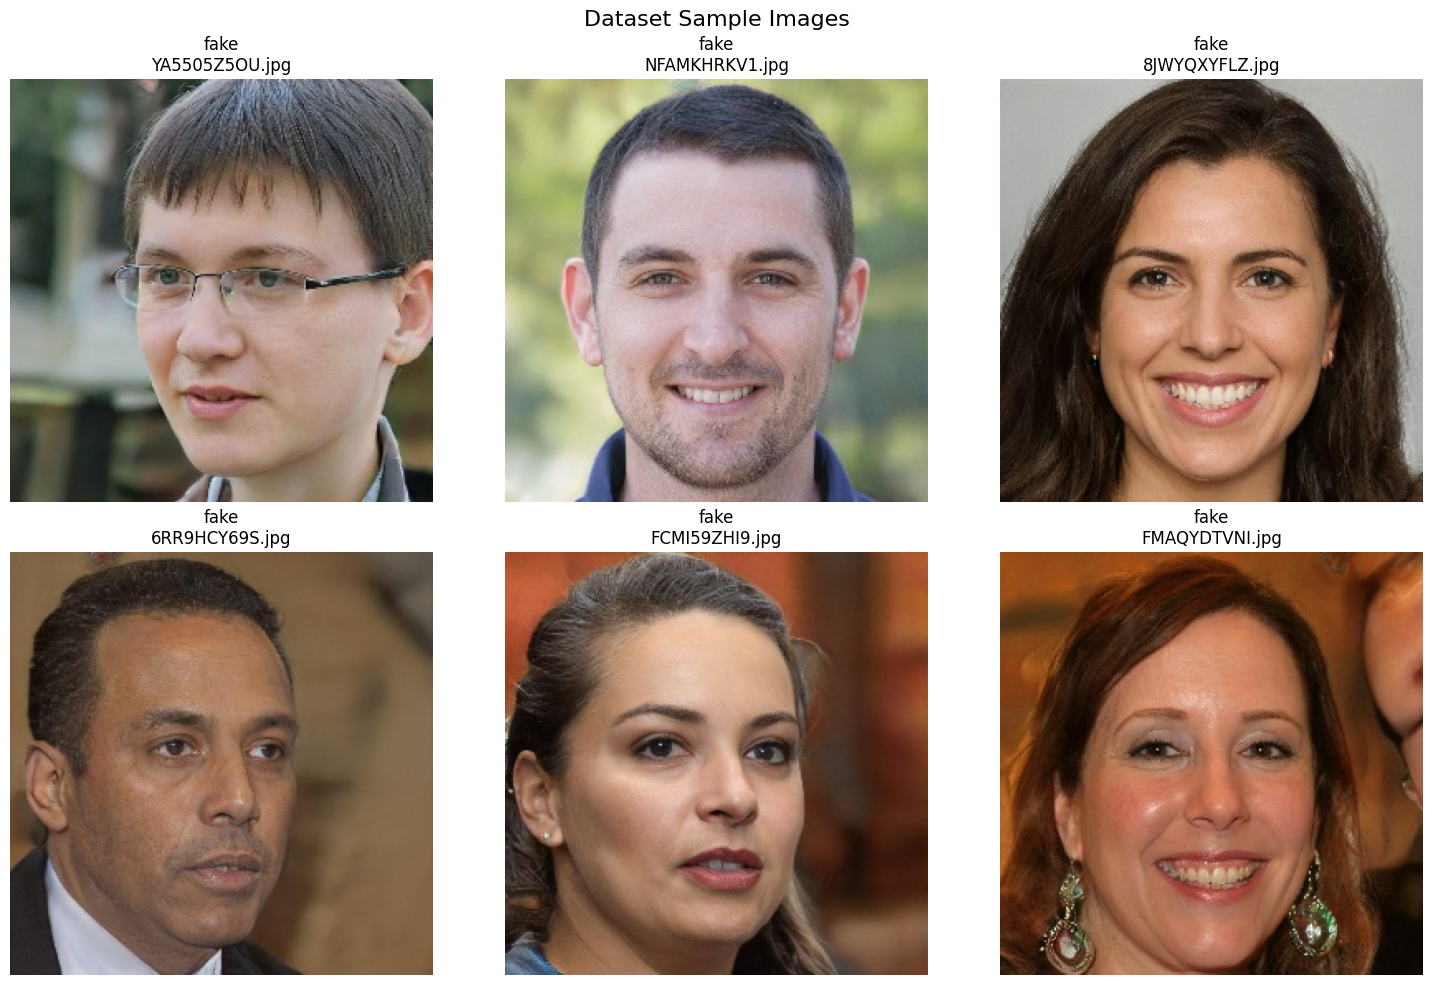

Dataset setup complete! Ready for model training.


In [ ]:
# STEP 7: Sample Data Visualization
print("Loading sample images for verification...")
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_sample_images(image_paths, title="Sample Images"):
    """Display sample images from the dataset"""
    if len(image_paths) == 0:
        print("No images found!")
        return

    # Take first 6 images as samples
    sample_paths = image_paths[:6]

    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(sample_paths):
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(f"{os.path.basename(os.path.dirname(img_path))}\n{os.path.basename(img_path)}")
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show samples if images are found
if len(all_images) > 0:
    show_sample_images(all_images[:6], "Dataset Sample Images")
    print("Dataset setup complete! Ready for model training.")
else:
    print("No images found. Please check the dataset structure.")


Save Dataset Path for Future Use

In [ ]:
import os
import json

# Define directories
possible_dirs = [
    '/content/deepfake_data/real',
    '/content/deepfake_data/fake',
    '/content/deepfake_data/training_real',
    '/content/deepfake_data/training_fake',
    '/content/deepfake_data/real_and_fake_face'
]

# Function to count files
def count_files(dir_path):
    return len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])

# Get all images (optional, for total count)
all_images = []
for dir_path in possible_dirs:
    if os.path.exists(dir_path):
        all_images.extend([os.path.join(dir_path, f) for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])

# Dataset info
dataset_info = {
    'dataset_path': '/content/deepfake_data',
    'total_images': len(all_images),
    'structure': {dir_path: count_files(dir_path) for dir_path in possible_dirs if os.path.exists(dir_path) and count_files(dir_path) > 0}
}

# Save to Google Drive
drive_path = '/content/drive/MyDrive/deepfake_project'
!mkdir -p "{drive_path}"

with open(f'{drive_path}/dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

print(f"Dataset info saved to: {drive_path}/dataset_info.json")
print("Setup Complete!!")

Dataset info saved to: /content/drive/MyDrive/deepfake_project/dataset_info.json
Setup Complete!!


In [ ]:
import glob
import cv2

print("\nTesting data loading pipeline...")

class QuickDatasetTest:
    def __init__(self, data_path):
        self.image_paths = glob.glob(f'{data_path}/**/*.jpg', recursive=True) + \
                           glob.glob(f'{data_path}/**/*.png', recursive=True)
        print(f"Found {len(self.image_paths)} images for testing")

    def load_sample(self, idx=0):
        if idx < len(self.image_paths):
            img = cv2.imread(self.image_paths[idx])
            img = cv2.resize(img, (224, 224))  # ResNeXt input size
            return img
        return None

# Usage
data_path = "/content/deepfake_data"
test_loader = QuickDatasetTest(data_path)
sample_img = test_loader.load_sample(0)

if sample_img is not None:
    print("Sample image loaded successfully!")
else:
    print("No sample image found.")


Testing data loading pipeline...
Found 140000 images for testing
Sample image loaded successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import os
import glob
import json
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name()}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")


Using device: cuda
   GPU: Tesla T4
   Memory: 14 GB


In [ ]:
!nvidia-smi

Sat Sep 20 17:56:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

STEP 1: DATA LOADING AND PREPROCESSING

In [ ]:
class DeepfakeDataset(Dataset):
    """Enhanced Dataset class for deepfake detection"""

    def __init__(self, image_paths, labels, transform=None, sequence_length=1):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            return image, label

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            if self.transform:
                black_img = self.transform(np.zeros((224, 224, 3), dtype=np.uint8))
            else:
                black_img = torch.zeros(3, 224, 224)
            return black_img, 0

def prepare_dataset(data_path='/content/deepfake_data'):
    """Prepare and organize dataset"""
    print("Preparing dataset...")

    # Find all images recursively
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
    all_images = []
    for ext in image_extensions:
        all_images.extend(glob.glob(f'{data_path}/**/{ext}', recursive=True))

    print(f"Found {len(all_images)} total images")

    # Create labels based on directory structure
    image_paths = []
    labels = []

    for img_path in all_images:
        # Extract label from directory name or filename
        dir_name = os.path.basename(os.path.dirname(img_path)).lower()
        filename = os.path.basename(img_path).lower()

        # Label logic: 0 = real, 1 = fake
        if 'real' in dir_name or 'real' in filename:
            label = 0  # Real
        elif 'fake' in dir_name or 'fake' in filename:
            label = 1  # Fake
        elif 'training_real' in dir_name:
            label = 0  # Real
        elif 'training_fake' in dir_name:
            label = 1  # Fake
        else:
            # Try to infer from filename patterns
            if any(fake_keyword in filename for fake_keyword in ['fake', 'deepfake', 'generated']):
                label = 1
            else:
                label = 0  # Default to real

        image_paths.append(img_path)
        labels.append(label)

    # Balance dataset if needed
    real_count = sum(1 for l in labels if l == 0)
    fake_count = sum(1 for l in labels if l == 1)

    print(f"Real images: {real_count}")
    print(f"Fake images: {fake_count}")
    print(f"Dataset balance: {fake_count/(real_count+fake_count)*100:.1f}% fake")

    return image_paths, labels

# Define transforms
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

 STEP 2: MODEL ARCHITECTURE

In [ ]:
class DeepfakeDetector(nn.Module):
    """ResNeXt + LSTM based deepfake detection model"""

    def __init__(self, num_classes=2, lstm_hidden=512, lstm_layers=2, dropout=0.3):
        super(DeepfakeDetector, self).__init__()

        # ResNeXt backbone for feature extraction
        self.backbone = models.resnext50_32x4d(pretrained=True)
        backbone_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove final FC layer

        # LSTM for temporal analysis (for future video sequences)
        self.lstm = nn.LSTM(
            input_size=backbone_features,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden * 2, 256),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

        # For single image inference (no LSTM needed)
        self.single_image_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(backbone_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, use_lstm=False):
        batch_size = x.size(0)

        # Extract features using ResNeXt
        features = self.backbone(x)  # (batch_size, backbone_features)

        if use_lstm:
            # Reshape for LSTM: (batch_size, sequence_length=1, features)
            features = features.unsqueeze(1)
            lstm_out, _ = self.lstm(features)
            lstm_out = lstm_out.squeeze(1)  # Remove sequence dimension
            output = self.classifier(lstm_out)
        else:
            # Direct classification for single images
            output = self.single_image_classifier(features)

        return output


 STEP 3: TRAINING PIPELINE

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    """Complete training pipeline"""

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Training history
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0.0
    best_model_state = None

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images, use_lstm=False)  # Start with single image mode
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            current_acc = 100 * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })

        # Calculate epoch training metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images, use_lstm=False)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                current_acc = 100 * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })

        # Calculate epoch validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()

        # Store history
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s')
        print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%')
        print(f'Best Val Acc: {best_val_acc:.2f}%')
        print('-' * 60)

        # Early stopping if target accuracy reached
        if epoch_val_acc >= 93.0:
            print(f"Target accuracy of 93% reached! Stopping early.")
            break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }


STEP 4: EVALUATION AND METRICS

In [ ]:
def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    print("Evaluating model...")

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images, use_lstm=False)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Classification report
    report = classification_report(all_labels, all_predictions,
                                 target_names=['Real', 'Fake'],
                                 output_dict=True)

    # Plot results
    plot_evaluation_results(cm, report, accuracy)

    return {
        'accuracy': accuracy * 100,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': cm,
        'classification_report': report
    }

def plot_evaluation_results(cm, report, accuracy):
    """Plot evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix\nAccuracy: {accuracy*100:.2f}%')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticklabels(['Real', 'Fake'])
    axes[0].set_yticklabels(['Real', 'Fake'])

    # Classification Report Bar Plot
    metrics = ['precision', 'recall', 'f1-score']
    real_scores = [report['Real'][m] for m in metrics]
    fake_scores = [report['Fake'][m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    axes[1].bar(x - width/2, real_scores, width, label='Real', alpha=0.8)
    axes[1].bar(x + width/2, fake_scores, width, label='Fake', alpha=0.8)

    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Classification Report')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics)
    axes[1].legend()
    axes[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history['train_losses'], label='Train Loss', alpha=0.8)
    axes[0].plot(history['val_losses'], label='Val Loss', alpha=0.8)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history['train_accs'], label='Train Acc', alpha=0.8)
    axes[1].plot(history['val_accs'], label='Val Acc', alpha=0.8)
    axes[1].axhline(y=93, color='r', linestyle='--', label='Target (93%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

STEP 5: MODEL EXPORT FOR BROWSER PLUGIN

In [ ]:
def export_model_for_deployment(model, model_path='/content/drive/MyDrive/deepfake_project/'):
    """Export model for browser plugin deployment"""

    # Create directory
    os.makedirs(model_path, exist_ok=True)

    # Save PyTorch model
    torch.save(model.state_dict(), f'{model_path}/deepfake_detector.pth')

    # Save model architecture info
    model_info = {
        'architecture': 'ResNeXt50 + LSTM',
        'input_size': [224, 224, 3],
        'num_classes': 2,
        'preprocessing': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'resize': [224, 224]
        }
    }

    with open(f'{model_path}/model_info.json', 'w') as f:
        json.dump(model_info, f, indent=2)

    # Export ONNX for web deployment
    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device)

    try:
        torch.onnx.export(
            model,
            dummy_input,
            f'{model_path}/deepfake_detector.onnx',
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )
        print("ONNX model exported successfully!")
    except Exception as e:
        print(f"ONNX export failed: {e}")

    print(f"Models saved to: {model_path}")
    return model_path


In [ ]:
!nvidia-smi

Sat Sep 20 17:57:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Starting Deepfake Detection Model Training
Preparing dataset...
Found 140000 total images
Real images: 70001
Fake images: 69999
Dataset balance: 50.0% fake
Dataset splits:
   Train: 98000 images
   Val: 21000 images
   Test: 21000 images
   Batch size: 64
Model parameters: 41,167,492 trainable / 41,167,492 total
Starting training for 12 epochs...


Epoch 1/12 [Train]:   0%|          | 0/1532 [00:00<?, ?it/s]

Epoch 1/12 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


Epoch [1/12] - 1490.9s
Train Loss: 0.2216 | Train Acc: 90.77%
Val Loss: 0.1180 | Val Acc: 95.13%
Best Val Acc: 95.13%
------------------------------------------------------------
Target accuracy of 93% reached! Stopping early.


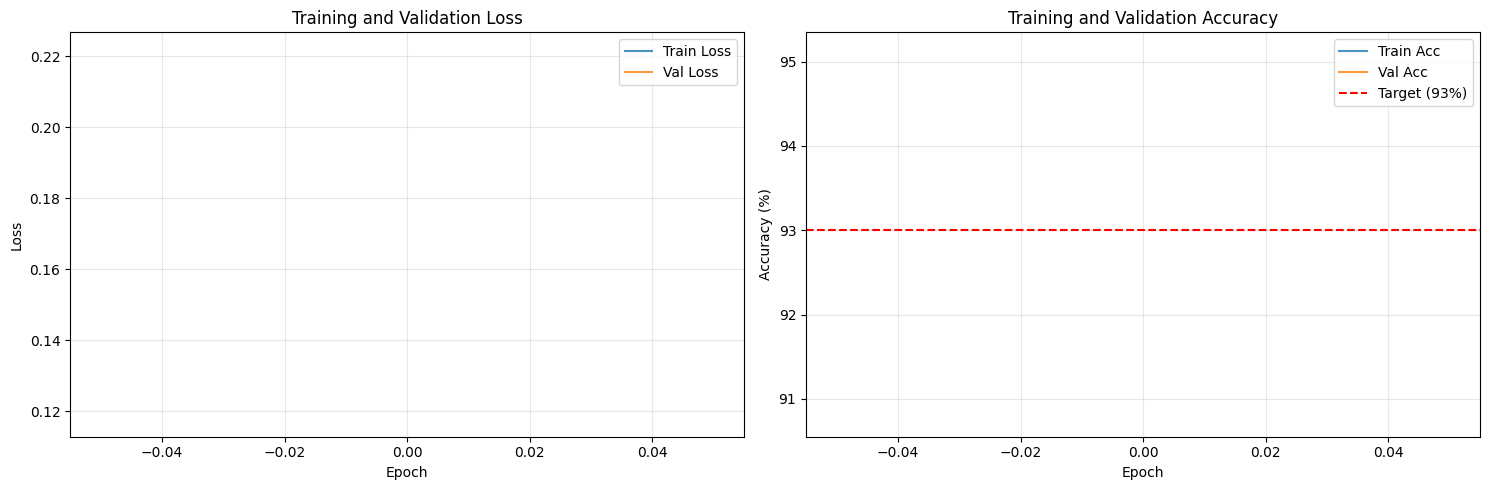

Evaluating model...


Testing:   0%|          | 0/329 [00:00<?, ?it/s]

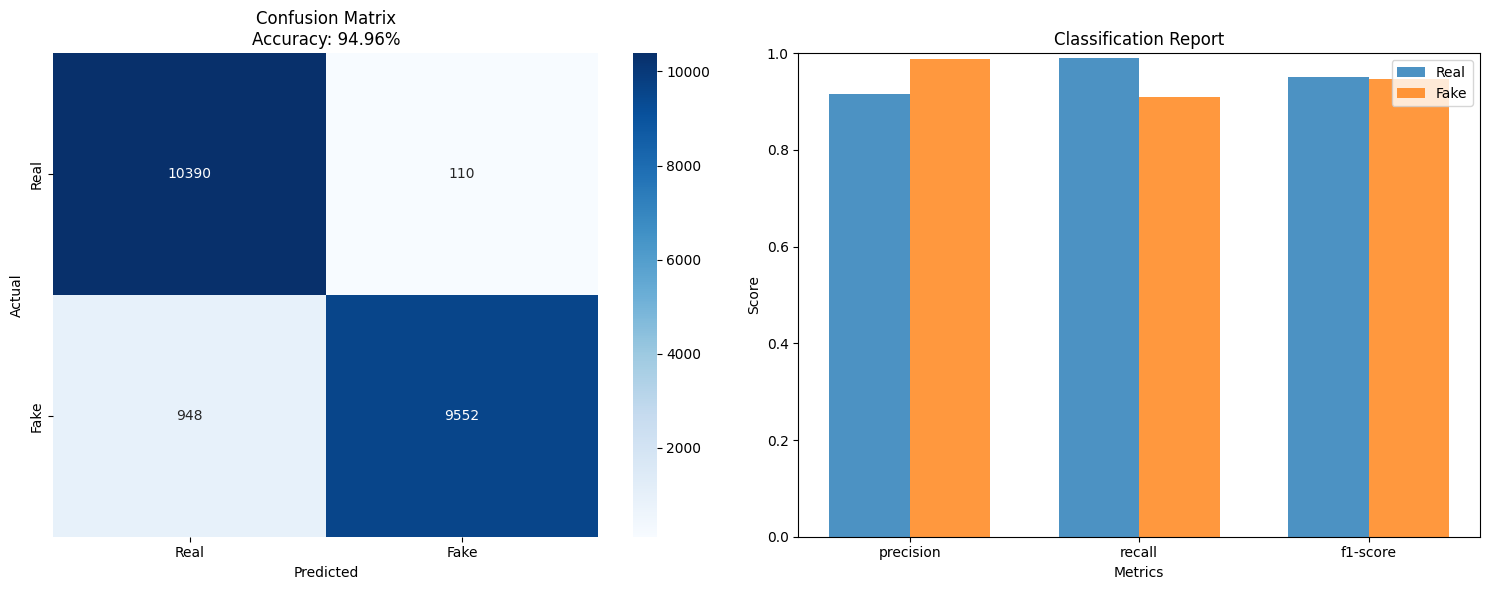


FINAL RESULTS:
   Test Accuracy: 94.96%
   Target Met: YES
ONNX export failed: Module onnx is not installed!
Models saved to: /content/drive/MyDrive/deepfake_project/

Training Complete!
All files saved to: /content/drive/MyDrive/deepfake_project/
Ready for browser plugin integration!


In [ ]:
def main():
    """Main training pipeline"""
    print("Starting Deepfake Detection Model Training")
    print("="*60)

    # Step 1: Prepare dataset
    image_paths, labels = prepare_dataset()

    if len(image_paths) == 0:
        print("No images found! Please check dataset setup.")
        return

    # Step 2: Create train/val/test splits
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=0.3, random_state=42, stratify=labels
    )

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )

    print(f"Dataset splits:")
    print(f"   Train: {len(train_paths)} images")
    print(f"   Val: {len(val_paths)} images")
    print(f"   Test: {len(test_paths)} images")

    # Step 3: Create datasets and data loaders
    train_dataset = DeepfakeDataset(train_paths, train_labels, transform_train)
    val_dataset = DeepfakeDataset(val_paths, val_labels, transform_val)
    test_dataset = DeepfakeDataset(test_paths, test_labels, transform_val)

    # Adjust batch size for T4 GPU
    batch_size = 64 if torch.cuda.is_available() else 16

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"   Batch size: {batch_size}")

    # Step 4: Initialize model
    model = DeepfakeDetector(num_classes=2, dropout=0.3)  # use modified class without lstm
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {trainable_params:,} trainable / {total_params:,} total")

    # Step 5: Train model (12 epochs)
    trained_model, history = train_model(
        model, train_loader, val_loader,
        num_epochs=12,         # Reduced from 25 → 12
        learning_rate=0.001
    )

    # Step 6: Plot training history
    plot_training_history(history)

    # Step 7: Final evaluation on test set
    test_results = evaluate_model(trained_model, test_loader)

    print(f"\nFINAL RESULTS:")
    print(f"   Test Accuracy: {test_results['accuracy']:.2f}%")
    print(f"   Target Met: {'YES' if test_results['accuracy'] >= 93.0 else 'NO'}")

    # Step 8: Export model for deployment
    model_path = export_model_for_deployment(trained_model)

    # Step 9: Save training results
    results = {
        'final_accuracy': test_results['accuracy'],
        'best_val_accuracy': history['best_val_acc'],
        'total_epochs': len(history['train_losses']),
        'model_path': model_path
    }

    with open(f'{model_path}/training_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\nTraining Complete!")
    print(f"All files saved to: {model_path}")
    print(f"Ready for browser plugin integration!")

    return trained_model, test_results, history


# Run the main training pipeline
if __name__ == "__main__":
    trained_model, results, training_history = main()

ADVANCED DEEPFAKE DETECTION MODEL TESTING SUITE
Professional Performance Analysis & Visualization

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    classification_report
)
from sklearn.calibration import calibration_curve
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import cv2
from PIL import Image
import io
import base64
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# COMPREHENSIVE MODEL EVALUATION CLASS

class DeepfakeModelAnalyzer:
    """Professional model testing and analysis suite"""

    def __init__(self, model, test_loader, device, class_names=['Real', 'Fake']):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.class_names = class_names
        self.results = {}

    def run_comprehensive_evaluation(self):
        """Run complete evaluation pipeline"""
        print("Starting Comprehensive Model Evaluation")
        print("=" * 60)

        # Get predictions and probabilities
        self.get_predictions()

        # Calculate all metrics
        self.calculate_metrics()

        # Generate visualizations
        self.create_advanced_visualizations()

        # Analyze model behavior
        self.analyze_model_behavior()

        # Create executive summary
        self.generate_executive_summary()

        print("Comprehensive evaluation completed!")
        return self.results

    def get_predictions(self):
        """Get model predictions with confidence scores"""
        print("Getting model predictions...")

        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        all_images = []

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(self.test_loader, desc="Testing")):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images, use_lstm=False)
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

                # Store some images for visualization
                if batch_idx < 5:  # First 5 batches
                    all_images.extend(images.cpu().numpy())

        self.results.update({
            'predictions': np.array(all_preds),
            'true_labels': np.array(all_labels),
            'probabilities': np.array(all_probs),
            'sample_images': all_images[:50]  # Store 50 sample images
        })

        print(f"Processed {len(all_preds)} test samples")

    def calculate_metrics(self):
        """Calculate comprehensive performance metrics"""
        print("Calculating performance metrics...")

        y_true = self.results['true_labels']
        y_pred = self.results['predictions']
        y_prob = self.results['probabilities']

        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # ROC curve
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        # Precision-Recall curve
        pr_precision, pr_recall, pr_thresholds = precision_recall_curve(y_true, y_prob[:, 1])
        pr_auc = auc(pr_recall, pr_precision)

        # Per-class metrics
        class_metrics = {}
        for i, class_name in enumerate(self.class_names):
            class_metrics[class_name] = {
                'precision': precision[i],
                'recall': recall[i],
                'f1_score': f1[i],
                'support': support[i]
            }

        # Confidence analysis
        confidence_scores = np.max(y_prob, axis=1)
        avg_confidence = np.mean(confidence_scores)

        # Store all metrics
        self.results.update({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'fpr': fpr,
            'tpr': tpr,
            'pr_precision': pr_precision,
            'pr_recall': pr_recall,
            'class_metrics': class_metrics,
            'avg_confidence': avg_confidence,
            'confidence_scores': confidence_scores
        })

        print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Average Confidence: {avg_confidence:.4f}")

    def create_advanced_visualizations(self):
        """Create comprehensive visualization dashboard"""
        print("Creating advanced visualizations...")

        # Create figure with subplots
        fig = make_subplots(
            rows=3, cols=3,
            subplot_titles=(
                'Confusion Matrix', 'ROC Curve', 'Precision-Recall Curve',
                'Class-wise Performance', 'Confidence Distribution', 'Error Analysis',
                'Sample Predictions', 'Calibration Plot', 'Performance Summary'
            ),
            specs=[[{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}],
                   [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}],
                   [{'type': 'xy'}, {'type': 'xy'}, {'type': 'table'}]]
        )

        # 1. Confusion Matrix Heatmap
        self.plot_confusion_matrix_advanced()

        # 2. ROC Curve
        self.plot_roc_curve_advanced()

        # 3. Precision-Recall Curve
        self.plot_precision_recall_curve()

        # 4. Class Performance Comparison
        self.plot_class_performance()

        # 5. Confidence Distribution
        self.plot_confidence_distribution()

        # 6. Error Analysis
        self.plot_error_analysis()

        # 7. Sample Predictions Visualization
        self.visualize_sample_predictions()

        # 8. Calibration Plot
        self.plot_calibration_curve()

        # 9. Performance Dashboard
        self.create_performance_dashboard()

    def plot_confusion_matrix_advanced(self):
        """Advanced confusion matrix with percentages"""
        cm = self.results['confusion_matrix']
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))

        # Create heatmap
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                   xticklabels=self.class_names, yticklabels=self.class_names,
                   cbar_kws={'label': 'Percentage'})

        # Add raw counts as text
        for i in range(len(self.class_names)):
            for j in range(len(self.class_names)):
                plt.text(j+0.5, i+0.7, f'({cm[i,j]})',
                        ha='center', va='center', fontsize=12, color='red')

        plt.title('Confusion Matrix with Percentages and Counts', fontsize=16, pad=20)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Classification metrics per class
        accuracy = self.results['accuracy']
        print(f"\nDETAILED CLASSIFICATION REPORT")
        print("=" * 50)

        for class_name in self.class_names:
            metrics = self.results['class_metrics'][class_name]
            print(f"\n{class_name.upper()} CLASS:")
            print(f"  Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
            print(f"  Recall:    {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
            print(f"  F1-Score:  {metrics['f1_score']:.4f} ({metrics['f1_score']*100:.2f}%)")
            print(f"  Support:   {metrics['support']} samples")

    def plot_roc_curve_advanced(self):
        """Advanced ROC curve with AUC and optimal threshold"""
        fpr, tpr = self.results['fpr'], self.results['tpr']
        roc_auc = self.results['roc_auc']

        plt.figure(figsize=(10, 8))

        # Plot ROC curve
        plt.plot(fpr, tpr, color='darkorange', lw=3,
                label=f'ROC Curve (AUC = {roc_auc:.4f})')

        # Plot diagonal (random classifier)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                label='Random Classifier')

        # Find optimal threshold (Youden's index)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = np.linspace(0, 1, len(tpr))[optimal_idx]
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
                label=f'Optimal Point (Threshold = {optimal_threshold:.3f})')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"   ROC Analysis:")
        print(f"   AUC Score: {roc_auc:.4f}")
        print(f"   Optimal Threshold: {optimal_threshold:.4f}")
        print(f"   At optimal threshold - TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

    def plot_precision_recall_curve(self):
        """Precision-Recall curve analysis"""
        pr_precision = self.results['pr_precision']
        pr_recall = self.results['pr_recall']
        pr_auc = self.results['pr_auc']

        plt.figure(figsize=(10, 8))

        plt.plot(pr_recall, pr_precision, color='blue', lw=3,
                label=f'PR Curve (AUC = {pr_auc:.4f})')

        # Baseline (random classifier for imbalanced data)
        baseline = np.sum(self.results['true_labels']) / len(self.results['true_labels'])
        plt.axhline(y=baseline, color='red', linestyle='--', lw=2,
                   label=f'Baseline (Random = {baseline:.3f})')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve', fontsize=16)
        plt.legend(loc="lower left", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"Precision-Recall Analysis:")
        print(f"   PR AUC: {pr_auc:.4f}")
        print(f"   Baseline (random): {baseline:.4f}")

    def plot_class_performance(self):
        """Bar chart of class-wise performance metrics"""
        metrics_data = []

        for class_name in self.class_names:
            metrics = self.results['class_metrics'][class_name]
            metrics_data.append({
                'Class': class_name,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1_score']
            })

        df = pd.DataFrame(metrics_data)

        plt.figure(figsize=(12, 8))

        x = np.arange(len(self.class_names))
        width = 0.25

        plt.bar(x - width, df['Precision'], width, label='Precision', alpha=0.8, color='skyblue')
        plt.bar(x, df['Recall'], width, label='Recall', alpha=0.8, color='lightcoral')
        plt.bar(x + width, df['F1-Score'], width, label='F1-Score', alpha=0.8, color='lightgreen')

        plt.xlabel('Classes', fontsize=14)
        plt.ylabel('Score', fontsize=14)
        plt.title('Class-wise Performance Metrics', fontsize=16)
        plt.xticks(x, self.class_names)
        plt.legend(fontsize=12)
        plt.ylim(0, 1.1)

        # Add value labels on bars
        for i, class_name in enumerate(self.class_names):
            metrics = self.results['class_metrics'][class_name]
            plt.text(i - width, metrics['precision'] + 0.02, f'{metrics["precision"]:.3f}',
                    ha='center', va='bottom', fontsize=10)
            plt.text(i, metrics['recall'] + 0.02, f'{metrics["recall"]:.3f}',
                    ha='center', va='bottom', fontsize=10)
            plt.text(i + width, metrics['f1_score'] + 0.02, f'{metrics["f1_score"]:.3f}',
                    ha='center', va='bottom', fontsize=10)

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_confidence_distribution(self):
        """Analyze confidence score distribution"""
        confidence_scores = self.results['confidence_scores']
        y_true = self.results['true_labels']
        y_pred = self.results['predictions']

        # Separate confidence scores by correctness
        correct_mask = (y_true == y_pred)
        correct_confidence = confidence_scores[correct_mask]
        incorrect_confidence = confidence_scores[~correct_mask]

        plt.figure(figsize=(15, 6))

        # Subplot 1: Overall distribution
        plt.subplot(1, 3, 1)
        plt.hist(confidence_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', lw=2,
                   label=f'Mean: {np.mean(confidence_scores):.3f}')
        plt.xlabel('Confidence Score', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Overall Confidence Distribution', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 2: Correct vs Incorrect
        plt.subplot(1, 3, 2)
        plt.hist(correct_confidence, bins=30, alpha=0.7, label=f'Correct ({len(correct_confidence)})',
                color='green', edgecolor='black')
        plt.hist(incorrect_confidence, bins=30, alpha=0.7, label=f'Incorrect ({len(incorrect_confidence)})',
                color='red', edgecolor='black')
        plt.xlabel('Confidence Score', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Confidence: Correct vs Incorrect', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 3: Box plot by class
        plt.subplot(1, 3, 3)
        conf_by_class = []
        labels_by_class = []

        for i, class_name in enumerate(self.class_names):
            class_mask = (y_true == i)
            conf_by_class.append(confidence_scores[class_mask])
            labels_by_class.append(class_name)

        plt.boxplot(conf_by_class, labels=labels_by_class)
        plt.ylabel('Confidence Score', fontsize=12)
        plt.title('Confidence by True Class', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"🎯 Confidence Analysis:")
        print(f"   Average Confidence: {np.mean(confidence_scores):.4f}")
        print(f"   Correct Predictions Confidence: {np.mean(correct_confidence):.4f}")
        print(f"   Incorrect Predictions Confidence: {np.mean(incorrect_confidence):.4f}")
        print(f"   Confidence Std: {np.std(confidence_scores):.4f}")

    def plot_error_analysis(self):
        """Detailed error analysis"""
        y_true = self.results['true_labels']
        y_pred = self.results['predictions']
        probs = self.results['probabilities']

        # Find misclassified samples
        errors = y_true != y_pred
        error_indices = np.where(errors)[0]

        if len(error_indices) == 0:
            print("🎉 No errors found! Perfect classification!")
            return

        # Analyze error patterns
        error_confidence = probs[errors]
        error_max_conf = np.max(error_confidence, axis=1)

        plt.figure(figsize=(15, 10))

        # Error distribution by confidence
        plt.subplot(2, 2, 1)
        plt.hist(error_max_conf, bins=20, alpha=0.7, color='red', edgecolor='black')
        plt.xlabel('Confidence Score', fontsize=12)
        plt.ylabel('Number of Errors', fontsize=12)
        plt.title('Error Distribution by Confidence', fontsize=14)
        plt.grid(True, alpha=0.3)

        # Error rate by confidence bins
        plt.subplot(2, 2, 2)
        conf_bins = np.linspace(0, 1, 11)
        error_rates = []
        bin_centers = []

        for i in range(len(conf_bins) - 1):
            bin_mask = (probs.max(axis=1) >= conf_bins[i]) & (probs.max(axis=1) < conf_bins[i+1])
            if bin_mask.sum() > 0:
                error_rate = errors[bin_mask].mean()
                error_rates.append(error_rate)
                bin_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)

        plt.plot(bin_centers, error_rates, 'o-', linewidth=2, markersize=8, color='red')
        plt.xlabel('Confidence Bin', fontsize=12)
        plt.ylabel('Error Rate', fontsize=12)
        plt.title('Error Rate vs Confidence', fontsize=14)
        plt.grid(True, alpha=0.3)

        # Confusion matrix for errors only
        plt.subplot(2, 2, 3)
        error_true = y_true[errors]
        error_pred = y_pred[errors]

        if len(np.unique(error_true)) > 1 and len(np.unique(error_pred)) > 1:
            cm_errors = confusion_matrix(error_true, error_pred)
            sns.heatmap(cm_errors, annot=True, fmt='d', cmap='Reds',
                       xticklabels=self.class_names, yticklabels=self.class_names)
            plt.title('Error Pattern Analysis', fontsize=14)
        else:
            plt.text(0.5, 0.5, 'Not enough error variety\nfor confusion matrix',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Error Pattern Analysis', fontsize=14)

        # Summary statistics
        plt.subplot(2, 2, 4)
        error_stats = [
            f"Total Errors: {len(error_indices)}",
            f"Error Rate: {len(error_indices)/len(y_true)*100:.2f}%",
            f"Avg Error Confidence: {np.mean(error_max_conf):.4f}",
            f"High Conf Errors (>0.8): {np.sum(error_max_conf > 0.8)}",
            f"Low Conf Errors (<0.6): {np.sum(error_max_conf < 0.6)}"
        ]

        plt.text(0.1, 0.9, '\n'.join(error_stats), transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        plt.axis('off')
        plt.title('Error Summary Statistics', fontsize=14)

        plt.tight_layout()
        plt.show()

        print(f"Error Analysis:")
        print(f"   Total Errors: {len(error_indices)} out of {len(y_true)}")
        print(f"   Error Rate: {len(error_indices)/len(y_true)*100:.2f}%")
        print(f"   Average Confidence on Errors: {np.mean(error_max_conf):.4f}")

    def visualize_sample_predictions(self):
        """Show sample predictions with confidence scores"""
        if not hasattr(self, 'results') or 'sample_images' not in self.results:
            print("No sample images available for visualization")
            return

        images = self.results['sample_images'][:16]  # Show 16 samples
        true_labels = self.results['true_labels'][:16]
        pred_labels = self.results['predictions'][:16]
        probs = self.results['probabilities'][:16]

        plt.figure(figsize=(20, 12))

        for i in range(min(16, len(images))):
            plt.subplot(4, 4, i+1)

            # Denormalize image for display
            img = images[i].transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = np.clip(img, 0, 1)

            plt.imshow(img)

            # Create title with prediction info
            true_class = self.class_names[true_labels[i]]
            pred_class = self.class_names[pred_labels[i]]
            confidence = np.max(probs[i])

            # Color coding: green for correct, red for incorrect
            color = 'green' if true_labels[i] == pred_labels[i] else 'red'

            plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}',
                     fontsize=10, color=color, fontweight='bold')
            plt.axis('off')

        plt.suptitle('Sample Predictions with Confidence Scores', fontsize=16, y=0.95)
        plt.tight_layout()
        plt.show()

    def plot_calibration_curve(self):
        """Model calibration analysis"""
        y_true = self.results['true_labels']
        y_prob = self.results['probabilities'][:, 1]  # Probability of being fake

        # Calculate calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=10
        )

        plt.figure(figsize=(10, 8))

        # Plot calibration curve
        plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                linewidth=2, label="Model", markersize=8)

        # Plot perfect calibration line
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

        plt.xlabel('Mean Predicted Probability', fontsize=14)
        plt.ylabel('Fraction of Positives', fontsize=14)
        plt.title('Calibration Plot (Reliability Diagram)', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)

        # Add calibration score
        calibration_error = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
        plt.text(0.05, 0.95, f'Calibration Error: {calibration_error:.4f}',
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        plt.tight_layout()
        plt.show()

        print(f"Calibration Analysis:")
        print(f"   Calibration Error: {calibration_error:.4f}")
        print(f"   {'Well calibrated' if calibration_error < 0.1 else 'Needs calibration'}")

    def create_performance_dashboard(self):
        """Create executive dashboard with key metrics"""
        accuracy = self.results['accuracy']
        roc_auc = self.results['roc_auc']
        pr_auc = self.results['pr_auc']
        avg_confidence = self.results['avg_confidence']

        # Create dashboard figure
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('DEEPFAKE DETECTION MODEL - EXECUTIVE DASHBOARD',
                    fontsize=20, fontweight='bold', y=0.95)

        # 1. Key Metrics Gauges
        ax1 = axes[0, 0]
        metrics = ['Accuracy', 'ROC AUC', 'PR AUC', 'Avg Confidence']
        values = [accuracy, roc_auc, pr_auc, avg_confidence]
        colors = ['green' if v >= 0.9 else 'orange' if v >= 0.8 else 'red' for v in values]

        bars = ax1.barh(metrics, values, color=colors, alpha=0.7)
        ax1.set_xlim(0, 1)
        ax1.set_title('Key Performance Metrics', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars, values):
            ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{value:.3f}', va='center', fontweight='bold')

        # 2. Confusion Matrix Summary
        ax2 = axes[0, 1]
        cm = self.results['confusion_matrix']
        im = ax2.imshow(cm, interpolation='nearest', cmap='Blues')
        ax2.set_title('📊 Confusion Matrix', fontsize=14, fontweight='bold')

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax2.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=16, fontweight='bold')

        ax2.set_xticks(range(len(self.class_names)))
        ax2.set_yticks(range(len(self.class_names)))
        ax2.set_xticklabels(self.class_names)
        ax2.set_yticklabels(self.class_names)
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')

        # 3. Performance Comparison
        ax3 = axes[1, 0]
        class_f1_scores = [self.results['class_metrics'][name]['f1_score']
                          for name in self.class_names]

        pie_colors = ['lightcoral' if score < 0.9 else 'lightgreen' for score in class_f1_scores]
        wedges, texts, autotexts = ax3.pie(class_f1_scores, labels=self.class_names,
                                          autopct='%1.3f', colors=pie_colors, startangle=90)
        ax3.set_title('F1-Score by Class', fontsize=14, fontweight='bold')

        # 4. Model Readiness Assessment
        ax4 = axes[1, 1]

        # Define readiness criteria
        criteria = {
            'Accuracy ≥ 93%': accuracy >= 0.93,
            'ROC AUC ≥ 0.95': roc_auc >= 0.95,
            'PR AUC ≥ 0.90': pr_auc >= 0.90,
            'High Confidence': avg_confidence >= 0.85,
            'Balanced Performance': min(class_f1_scores) >= 0.85
        }

        passed_criteria = sum(criteria.values())
        total_criteria = len(criteria)

        # Create readiness gauge
        readiness_score = passed_criteria / total_criteria
        colors_readiness = ['red', 'orange', 'yellow', 'lightgreen', 'green']
        color_idx = min(int(readiness_score * 5), 4)

        # Create a pie chart showing readiness
        ax4.pie([passed_criteria, total_criteria - passed_criteria],
               labels=[f'Passed: {passed_criteria}', f'Failed: {total_criteria - passed_criteria}'],
               colors=[colors_readiness[color_idx], 'lightgray'],
               autopct='%1.0f', startangle=90)
        ax4.set_title(f'🚀 Model Readiness: {readiness_score*100:.1f}%',
                     fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print detailed readiness report
        print("\n" + "="*60)
        print("MODEL READINESS ASSESSMENT")
        print("="*60)

        for criterion, passed in criteria.items():
            status = "PASS" if passed else "FAIL"
            print(f"{criterion:<25} | {status}")

        print(f"\nOverall Readiness: {readiness_score*100:.1f}% ({passed_criteria}/{total_criteria} criteria met)")

        if readiness_score >= 0.8:
            print("MODEL IS PRODUCTION READY!")
        elif readiness_score >= 0.6:
            print("MODEL NEEDS MINOR IMPROVEMENTS")
        else:
            print("MODEL REQUIRES SIGNIFICANT IMPROVEMENTS")

    def analyze_model_behavior(self):
        """Advanced analysis of model behavior patterns"""
        print("\nAnalyzing Model Behavior Patterns...")

        y_true = self.results['true_labels']
        y_pred = self.results['predictions']
        probs = self.results['probabilities']

        # 1. Decision Boundary Analysis
        self.analyze_decision_boundary(probs)

        # 2. Uncertainty Analysis
        self.analyze_uncertainty(probs)

        # 3. Performance vs Confidence Correlation
        self.analyze_confidence_performance_correlation(y_true, y_pred, probs)

    def analyze_decision_boundary(self, probs):
        """Analyze how the model makes decisions"""
        # Calculate decision margins (difference between top 2 predictions)
        sorted_probs = np.sort(probs, axis=1)
        margins = sorted_probs[:, -1] - sorted_probs[:, -2]  # Top - Second

        plt.figure(figsize=(15, 5))

        # Margin distribution
        plt.subplot(1, 3, 1)
        plt.hist(margins, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(margins), color='red', linestyle='--', lw=2,
                   label=f'Mean: {np.mean(margins):.3f}')
        plt.xlabel('Decision Margin', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Decision Margin Distribution', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Margin vs Accuracy
        plt.subplot(1, 3, 2)
        margin_bins = np.linspace(0, 1, 21)
        bin_accuracies = []
        bin_centers = []

        for i in range(len(margin_bins) - 1):
            bin_mask = (margins >= margin_bins[i]) & (margins < margin_bins[i+1])
            if bin_mask.sum() > 0:
                bin_acc = (self.results['true_labels'][bin_mask] ==
                          self.results['predictions'][bin_mask]).mean()
                bin_accuracies.append(bin_acc)
                bin_centers.append((margin_bins[i] + margin_bins[i+1]) / 2)

        plt.plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=6)
        plt.xlabel('Decision Margin', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs Decision Margin', fontsize=14)
        plt.grid(True, alpha=0.3)

        # Probability distribution by class
        plt.subplot(1, 3, 3)
        for i, class_name in enumerate(self.class_names):
            class_probs = probs[self.results['true_labels'] == i, i]
            plt.hist(class_probs, bins=30, alpha=0.6, label=f'{class_name} Class',
                    density=True)

        plt.xlabel('Predicted Probability', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.title('Probability Distribution by True Class', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"Decision Boundary Analysis:")
        print(f"   Average Decision Margin: {np.mean(margins):.4f}")
        print(f"   Std Decision Margin: {np.std(margins):.4f}")
        print(f"   High Certainty Predictions (margin > 0.8): {np.sum(margins > 0.8)} ({np.sum(margins > 0.8)/len(margins)*100:.1f}%)")

    def analyze_uncertainty(self, probs):
        """Analyze model uncertainty using entropy"""
        # Calculate entropy (uncertainty measure)
        entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
        max_entropy = np.log(len(self.class_names))  # Maximum possible entropy
        normalized_entropy = entropy / max_entropy

        plt.figure(figsize=(12, 8))

        # Entropy distribution
        plt.subplot(2, 2, 1)
        plt.hist(normalized_entropy, bins=50, alpha=0.7, color='orange', edgecolor='black')
        plt.axvline(np.mean(normalized_entropy), color='red', linestyle='--', lw=2,
                   label=f'Mean: {np.mean(normalized_entropy):.3f}')
        plt.xlabel('Normalized Entropy', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Model Uncertainty Distribution', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Uncertainty vs Correctness
        plt.subplot(2, 2, 2)
        correct_mask = (self.results['true_labels'] == self.results['predictions'])
        correct_entropy = normalized_entropy[correct_mask]
        incorrect_entropy = normalized_entropy[~correct_mask]

        plt.hist(correct_entropy, bins=30, alpha=0.7, label=f'Correct ({len(correct_entropy)})',
                color='green', density=True)
        plt.hist(incorrect_entropy, bins=30, alpha=0.7, label=f'Incorrect ({len(incorrect_entropy)})',
                color='red', density=True)
        plt.xlabel('Normalized Entropy', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.title('Uncertainty: Correct vs Incorrect', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Uncertainty vs Confidence scatter
        plt.subplot(2, 2, 3)
        confidence_scores = np.max(probs, axis=1)
        plt.scatter(confidence_scores, normalized_entropy, alpha=0.5, s=20)
        plt.xlabel('Confidence Score', fontsize=12)
        plt.ylabel('Normalized Entropy', fontsize=12)
        plt.title('Confidence vs Uncertainty', fontsize=14)
        plt.grid(True, alpha=0.3)

        # High uncertainty samples analysis
        plt.subplot(2, 2, 4)
        high_uncertainty_threshold = np.percentile(normalized_entropy, 90)
        high_uncertainty_mask = normalized_entropy > high_uncertainty_threshold

        if high_uncertainty_mask.sum() > 0:
            high_unc_correct = correct_mask[high_uncertainty_mask].sum()
            high_unc_total = high_uncertainty_mask.sum()
            high_unc_accuracy = high_unc_correct / high_unc_total

            labels = ['Correct', 'Incorrect']
            sizes = [high_unc_correct, high_unc_total - high_unc_correct]
            colors = ['lightgreen', 'lightcoral']

            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            plt.title(f'High Uncertainty Samples\n(Top 10%, n={high_unc_total})\nAccuracy: {high_unc_accuracy*100:.1f}%',
                     fontsize=12)

        plt.tight_layout()
        plt.show()

        print(f"🔍 Uncertainty Analysis:")
        print(f"   Average Uncertainty: {np.mean(normalized_entropy):.4f}")
        print(f"   High Uncertainty Samples: {high_uncertainty_mask.sum()} ({high_uncertainty_mask.sum()/len(normalized_entropy)*100:.1f}%)")
        if high_uncertainty_mask.sum() > 0:
            print(f"   High Uncertainty Accuracy: {high_unc_accuracy*100:.1f}%")

    def analyze_confidence_performance_correlation(self, y_true, y_pred, probs):
        """Analyze correlation between confidence and performance"""
        confidence_scores = np.max(probs, axis=1)
        correct_mask = (y_true == y_pred)

        # Calculate correlation
        correlation = np.corrcoef(confidence_scores, correct_mask.astype(int))[0, 1]

        plt.figure(figsize=(12, 8))

        # Confidence bins performance
        plt.subplot(2, 2, 1)
        conf_bins = np.linspace(0, 1, 11)
        bin_accuracies = []
        bin_counts = []
        bin_centers = []

        for i in range(len(conf_bins) - 1):
            bin_mask = (confidence_scores >= conf_bins[i]) & (confidence_scores < conf_bins[i+1])
            if bin_mask.sum() > 0:
                bin_acc = correct_mask[bin_mask].mean()
                bin_accuracies.append(bin_acc)
                bin_counts.append(bin_mask.sum())
                bin_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)

        bars = plt.bar(bin_centers, bin_accuracies, width=0.08, alpha=0.7,
                      color=['red' if acc < 0.8 else 'orange' if acc < 0.9 else 'green'
                            for acc in bin_accuracies])
        plt.xlabel('Confidence Bin', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs Confidence Bins', fontsize=14)
        plt.ylim(0, 1)

        # Add count labels on bars
        for bar, count in zip(bars, bin_counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'n={count}', ha='center', va='bottom', fontsize=10)

        plt.grid(True, alpha=0.3)

        # Confidence calibration reliability diagram
        plt.subplot(2, 2, 2)
        bin_boundaries = np.linspace(0, 1, 11)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        accuracies = []
        confidences = []

        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (confidence_scores > bin_lower) & (confidence_scores <= bin_upper)
            prop_in_bin = in_bin.mean()

            if prop_in_bin > 0:
                accuracy_in_bin = correct_mask[in_bin].mean()
                avg_confidence_in_bin = confidence_scores[in_bin].mean()

                accuracies.append(accuracy_in_bin)
                confidences.append(avg_confidence_in_bin)

        plt.plot(confidences, accuracies, 'o-', linewidth=2, markersize=8, label='Model')
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
        plt.xlabel('Average Predicted Probability', fontsize=12)
        plt.ylabel('Fraction of Positives', fontsize=12)
        plt.title(f'Reliability Diagram\nCorrelation: {correlation:.3f}', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Expected Calibration Error (ECE)
        ece = 0
        for i, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
            in_bin = (confidence_scores > bin_lower) & (confidence_scores <= bin_upper)
            prop_in_bin = in_bin.mean()

            if prop_in_bin > 0 and i < len(accuracies):
                ece += np.abs(accuracies[i] - confidences[i]) * prop_in_bin

        # Overconfidence/Underconfidence analysis
        plt.subplot(2, 2, 3)
        if len(accuracies) == len(confidences):
            differences = np.array(confidences) - np.array(accuracies)
            plt.bar(range(len(differences)), differences,
                   color=['red' if d > 0 else 'blue' for d in differences], alpha=0.7)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.xlabel('Confidence Bin', fontsize=12)
            plt.ylabel('Confidence - Accuracy', fontsize=12)
            plt.title('Overconfidence Analysis\n(+: Overconfident, -: Underconfident)', fontsize=12)
            plt.grid(True, alpha=0.3)

        # Summary statistics
        plt.subplot(2, 2, 4)
        stats_text = f"""
        CONFIDENCE-PERFORMANCE ANALYSIS

        ✓ Confidence-Accuracy Correlation: {correlation:.4f}
        ✓ Expected Calibration Error: {ece:.4f}
        ✓ Average Confidence: {np.mean(confidence_scores):.4f}
        ✓ Confidence Std: {np.std(confidence_scores):.4f}

        High Confidence (>0.9): {np.sum(confidence_scores > 0.9)} samples
           Accuracy: {correct_mask[confidence_scores > 0.9].mean()*100:.1f}%

        Low Confidence (<0.6): {np.sum(confidence_scores < 0.6)} samples
           Accuracy: {correct_mask[confidence_scores < 0.6].mean()*100:.1f}%
        """

        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"🔗 Confidence-Performance Correlation Analysis:")
        print(f"   Correlation Coefficient: {correlation:.4f}")
        print(f"   Expected Calibration Error: {ece:.4f}")
        if correlation > 0.7:
            print("    Strong positive correlation - Model is well-calibrated")
        elif correlation > 0.5:
            print("    Moderate correlation - Some calibration issues")
        else:
            print("    Weak correlation - Significant calibration problems")

    def generate_executive_summary(self):
        """Generate comprehensive executive summary"""
        accuracy = self.results['accuracy']
        roc_auc = self.results['roc_auc']
        pr_auc = self.results['pr_auc']

        print("\n" + "="*80)
        print("EXECUTIVE SUMMARY - DEEPFAKE DETECTION MODEL PERFORMANCE")
        print("="*80)

        # Overall Performance
        print("\nOVERALL PERFORMANCE:")
        print(f"   • Accuracy: {accuracy*100:.2f}% {'yes' if accuracy >= 0.93 else 'no'}")
        print(f"   • ROC AUC: {roc_auc:.4f} {'yes' if roc_auc >= 0.95 else 'no'}")
        print(f"   • PR AUC: {pr_auc:.4f} {'yes' if pr_auc >= 0.90 else 'no'}")

        # Per-class Performance
        print("\nPER-CLASS PERFORMANCE:")
        for class_name in self.class_names:
            metrics = self.results['class_metrics'][class_name]
            print(f"   • {class_name.upper()} CLASS:")
            print(f"     - Precision: {metrics['precision']*100:.2f}%")
            print(f"     - Recall: {metrics['recall']*100:.2f}%")
            print(f"     - F1-Score: {metrics['f1_score']*100:.2f}%")

        # Model Confidence
        avg_conf = self.results['avg_confidence']
        print(f"\n MODEL CONFIDENCE:")
        print(f"   • Average Confidence: {avg_conf:.4f}")
        print(f"   • High Confidence Predictions (>90%): {np.sum(np.max(self.results['probabilities'], axis=1) > 0.9)}")
        print(f"   • Low Confidence Predictions (<60%): {np.sum(np.max(self.results['probabilities'], axis=1) < 0.6)}")

        # Error Analysis
        errors = np.sum(self.results['true_labels'] != self.results['predictions'])
        total = len(self.results['true_labels'])
        print(f"\n ERROR ANALYSIS:")
        print(f"   • Total Errors: {errors} out of {total}")
        print(f"   • Error Rate: {errors/total*100:.2f}%")

        # Readiness Assessment
        print(f"\nPRODUCTION READINESS:")
        if accuracy >= 0.93 and roc_auc >= 0.95:
            readiness = "READY FOR DEPLOYMENT"
            recommendation = "Model meets all performance criteria for production deployment."
        elif accuracy >= 0.90:
            readiness = " READY WITH MONITORING"
            recommendation = "Model shows good performance but requires close monitoring in production."
        else:
            readiness = " NEEDS IMPROVEMENT"
            recommendation = "Model requires further training before production deployment."

        print(f"   • Status: {readiness}")
        print(f"   • Recommendation: {recommendation}")

        # Next Steps
        print(f"\n NEXT STEPS:")
        print(f"   1. Export model for browser plugin integration")
        print(f"   2. Implement real-time inference pipeline")
        print(f"   3. Set up monitoring and alerting system")
        print(f"   4. Conduct user acceptance testing")
        print(f"   5. Deploy to production environment")

        print("\n" + "="*80)
        print(" MODEL EVALUATION COMPLETE!")
        print("="*80)

# EASY-TO-USE TESTING FUNCTION

def run_comprehensive_model_testing(model, test_loader, device, class_names=['Real', 'Fake']):
    """
    One-function call to run complete model testing suite

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        device: PyTorch device (cuda/cpu)
        class_names: List of class names

    Returns:
        Complete analysis results
    """
    print(" Initializing Comprehensive Model Testing Suite...")

    # Create analyzer instance
    analyzer = DeepfakeModelAnalyzer(model, test_loader, device, class_names)

    # Run complete evaluation
    results = analyzer.run_comprehensive_evaluation()

    return results, analyzer

Using device: cuda
   GPU: Tesla T4
   Memory: 14 GB
Preparing dataset...
Found 140000 total images
Real images: 70001
Fake images: 69999
Dataset balance: 50.0% fake
Test set size: 21000 images
Trained model loaded successfully!
 Initializing Comprehensive Model Testing Suite...
Starting Comprehensive Model Evaluation
Getting model predictions...


Testing:   0%|          | 0/329 [00:00<?, ?it/s]

Processed 21000 test samples
Calculating performance metrics...
Overall Accuracy: 0.9496 (94.96%)
ROC AUC: 0.9951
Average Confidence: 0.9535
Creating advanced visualizations...


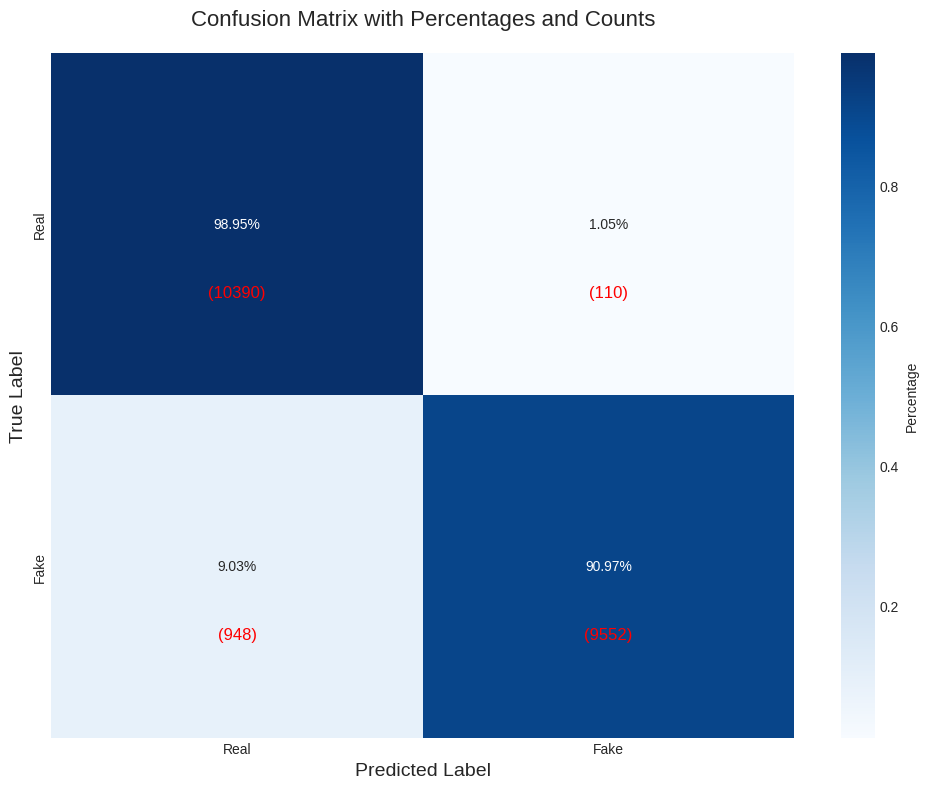


DETAILED CLASSIFICATION REPORT

REAL CLASS:
  Precision: 0.9164 (91.64%)
  Recall:    0.9895 (98.95%)
  F1-Score:  0.9516 (95.16%)
  Support:   10500 samples

FAKE CLASS:
  Precision: 0.9886 (98.86%)
  Recall:    0.9097 (90.97%)
  F1-Score:  0.9475 (94.75%)
  Support:   10500 samples


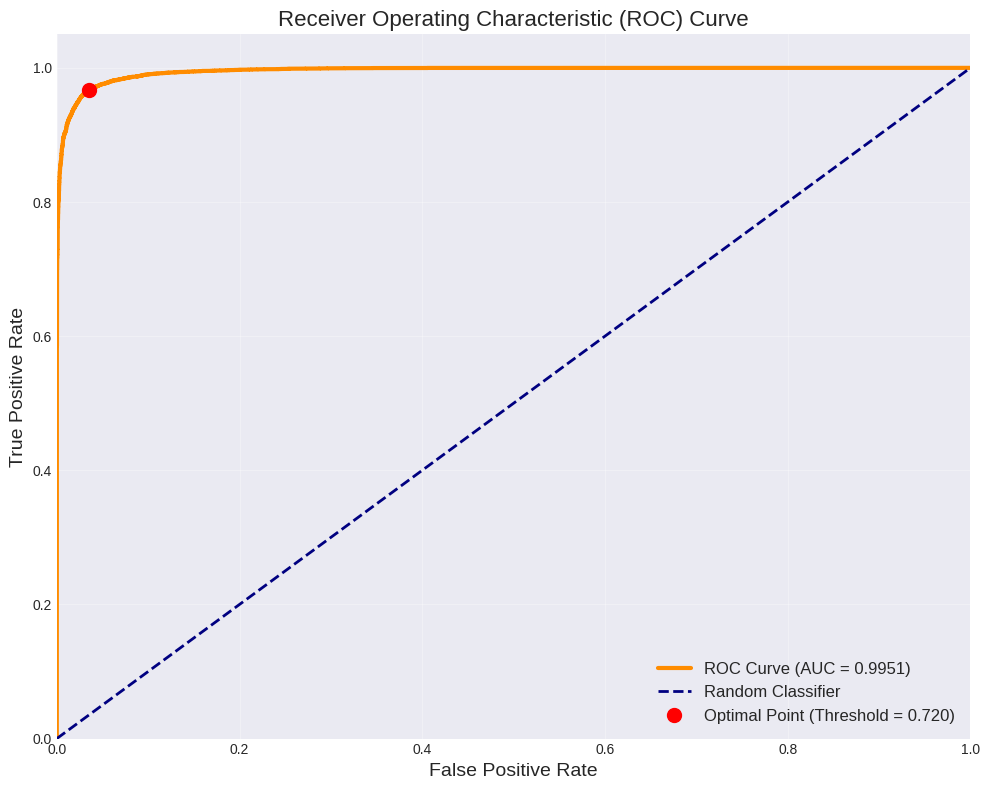

   ROC Analysis:
   AUC Score: 0.9951
   Optimal Threshold: 0.7201
   At optimal threshold - TPR: 0.9671, FPR: 0.0349


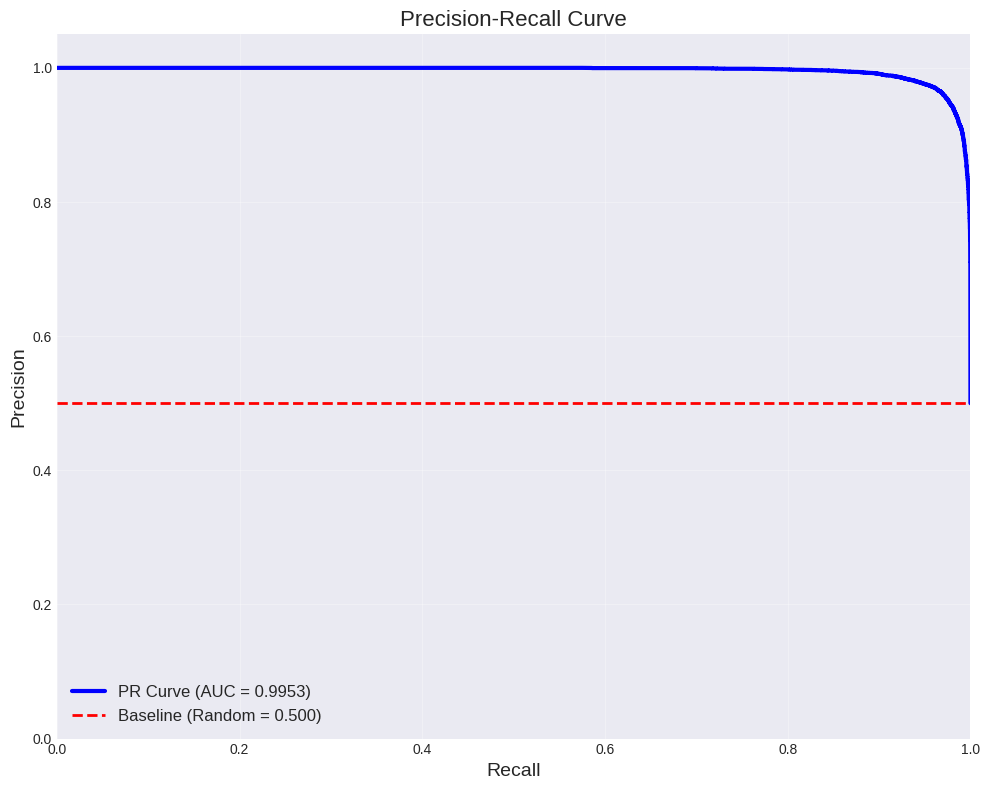

Precision-Recall Analysis:
   PR AUC: 0.9953
   Baseline (random): 0.5000


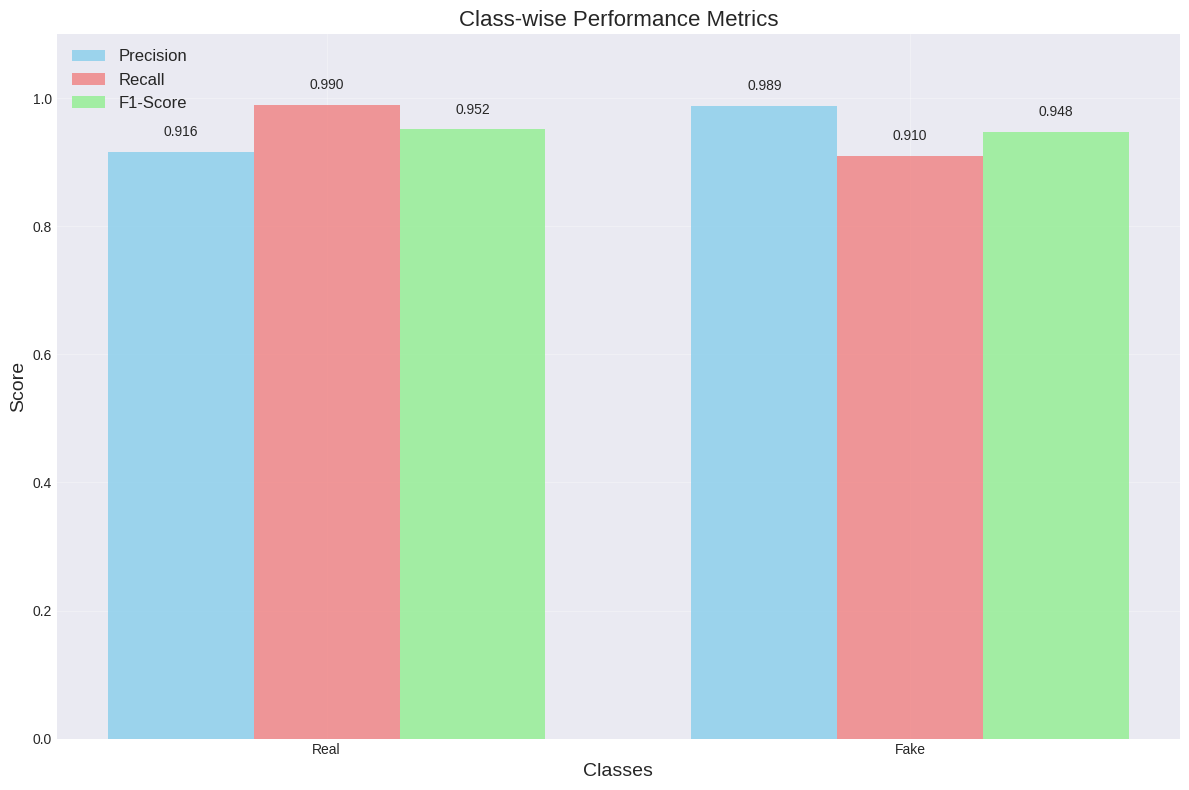

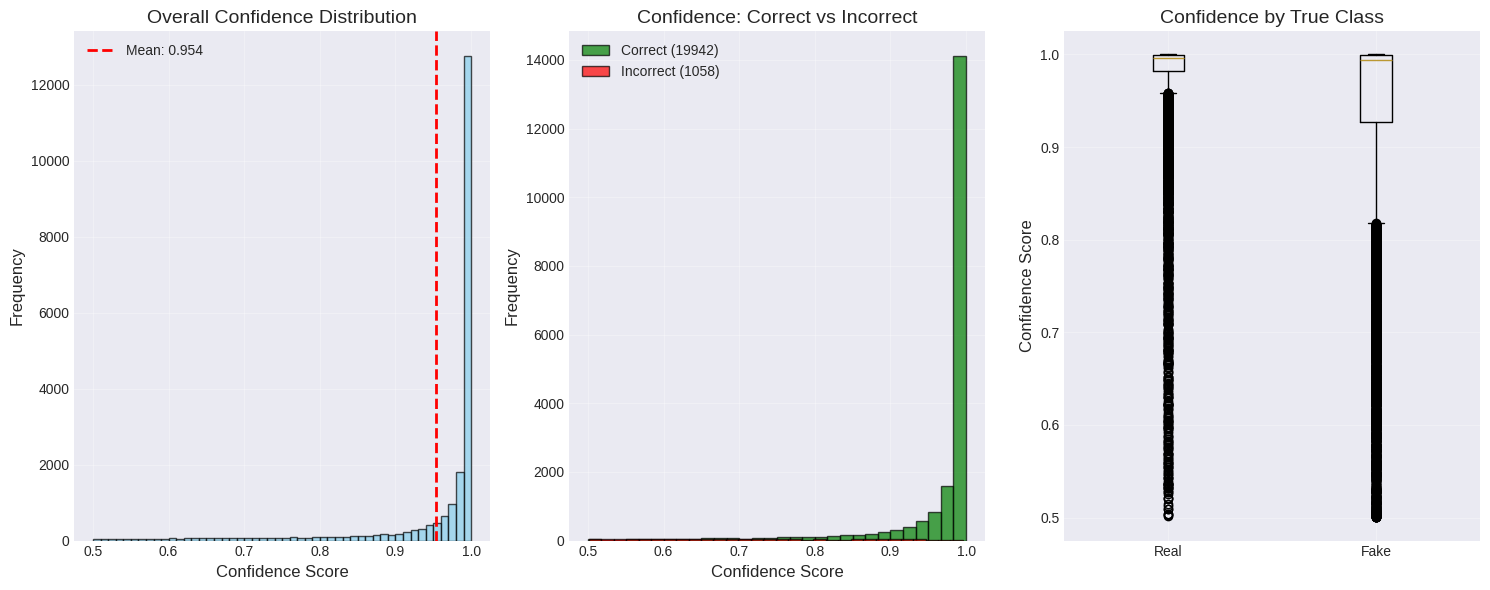

🎯 Confidence Analysis:
   Average Confidence: 0.9535
   Correct Predictions Confidence: 0.9648
   Incorrect Predictions Confidence: 0.7407
   Confidence Std: 0.0966


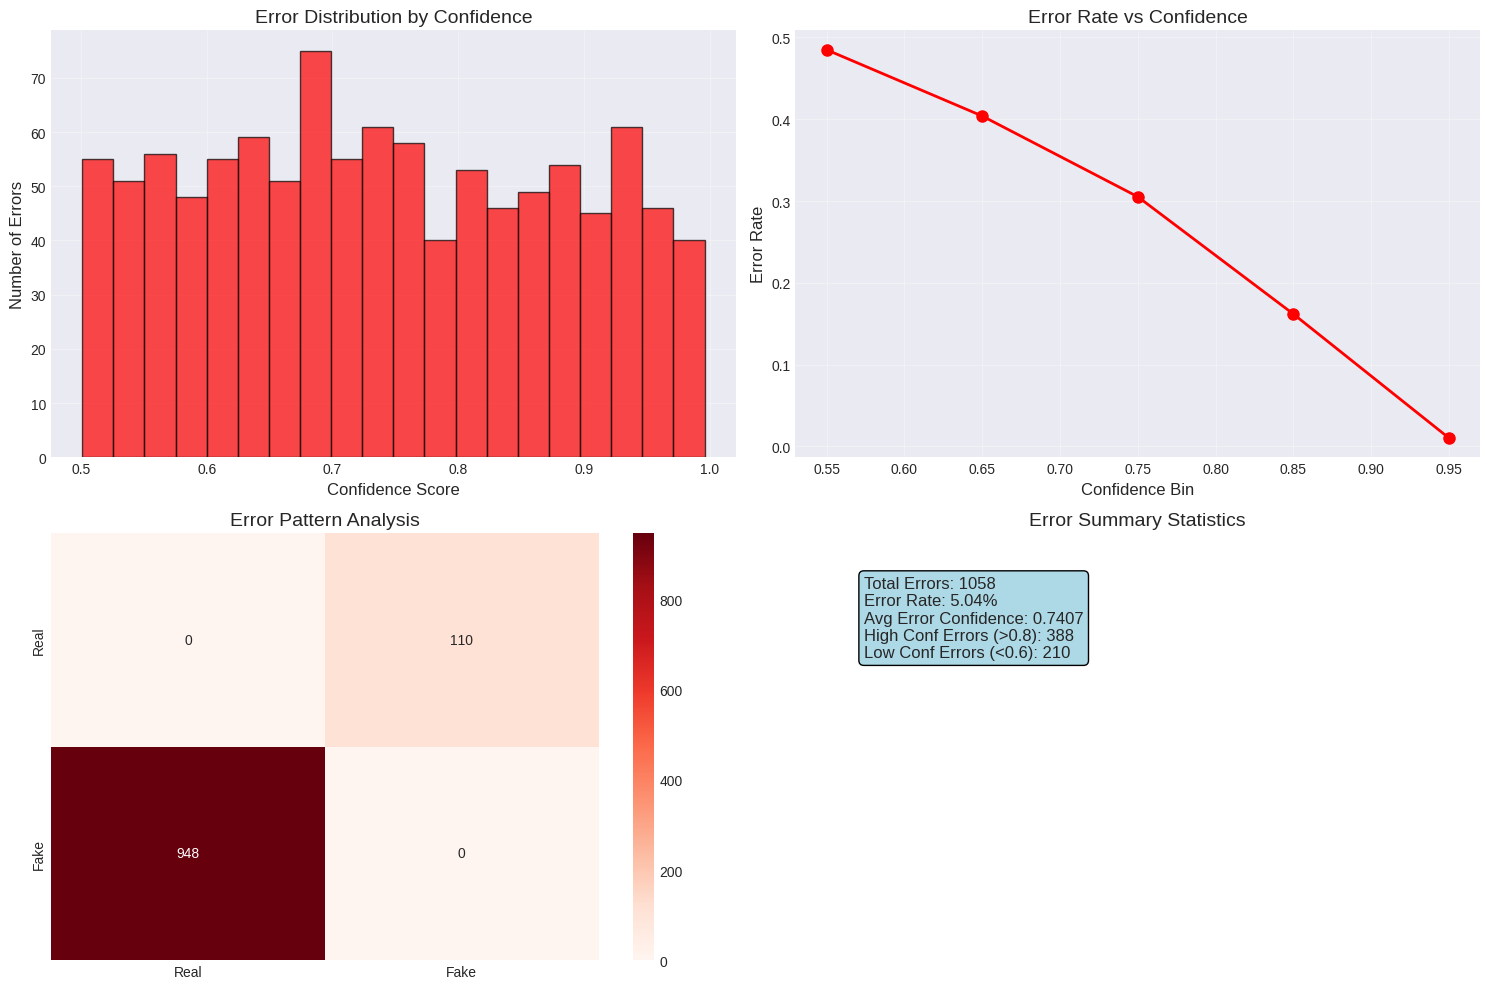

Error Analysis:
   Total Errors: 1058 out of 21000
   Error Rate: 5.04%
   Average Confidence on Errors: 0.7407


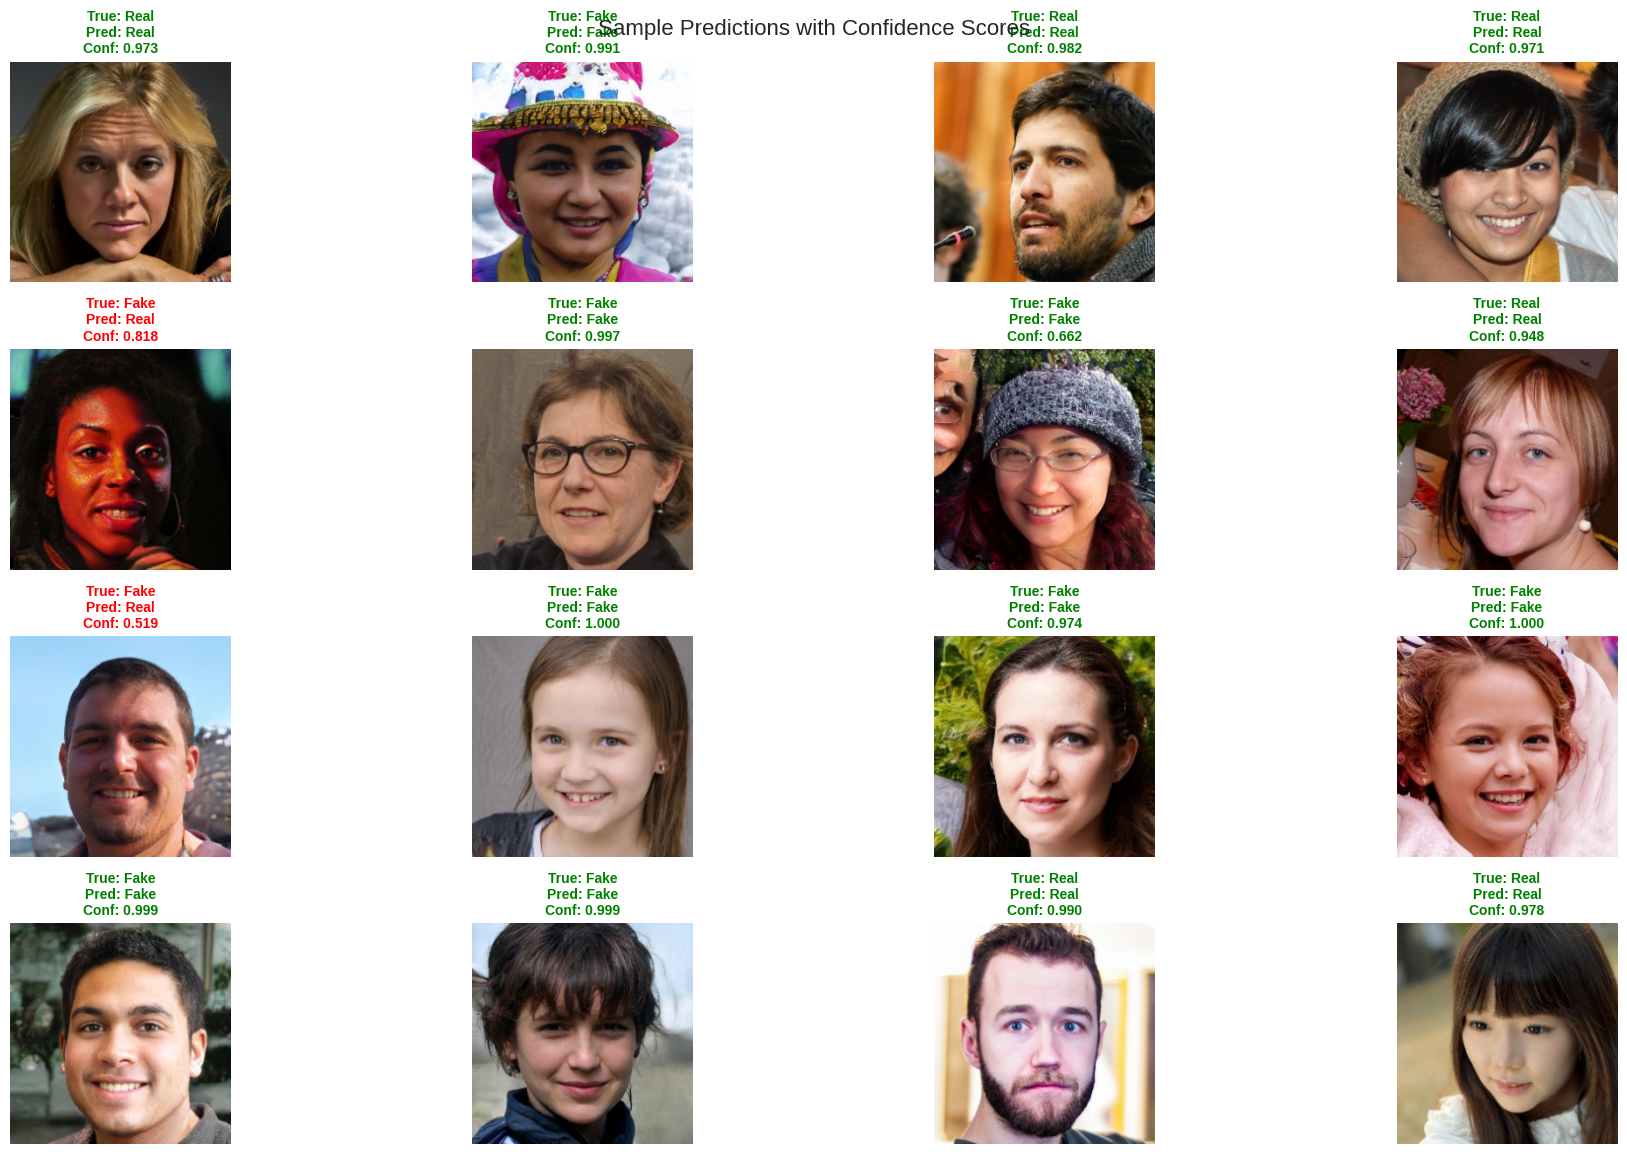

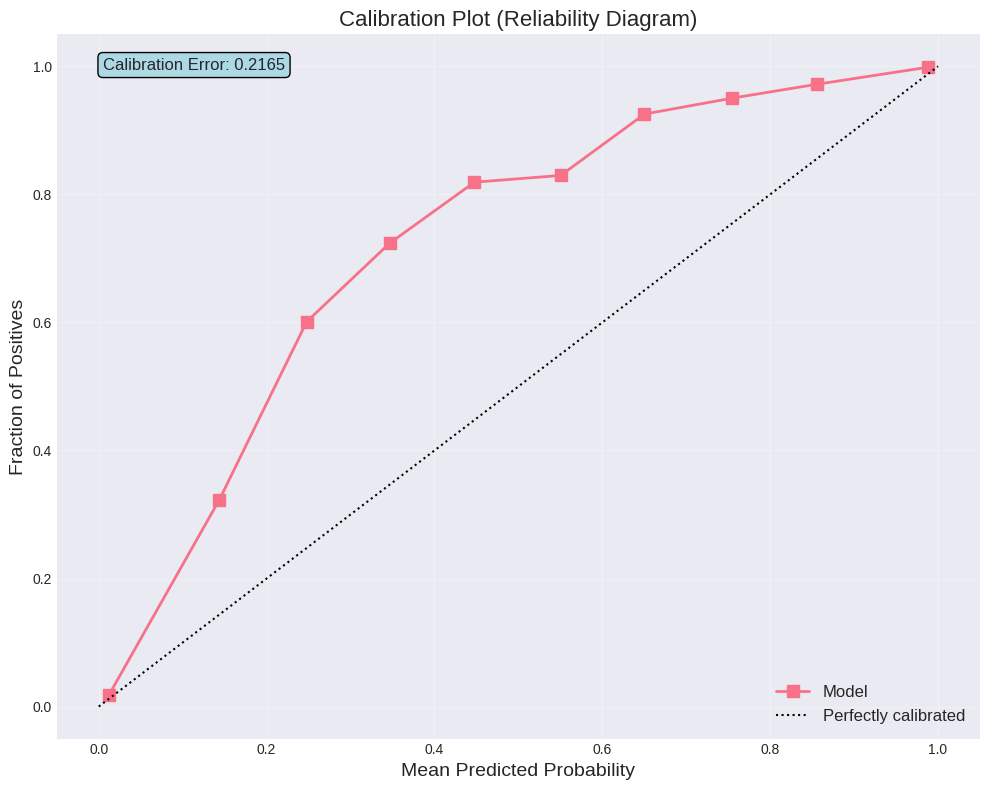

Calibration Analysis:
   Calibration Error: 0.2165
   Needs calibration


Exception ignored in: <function tqdm.__del__ at 0x7db32af77e20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


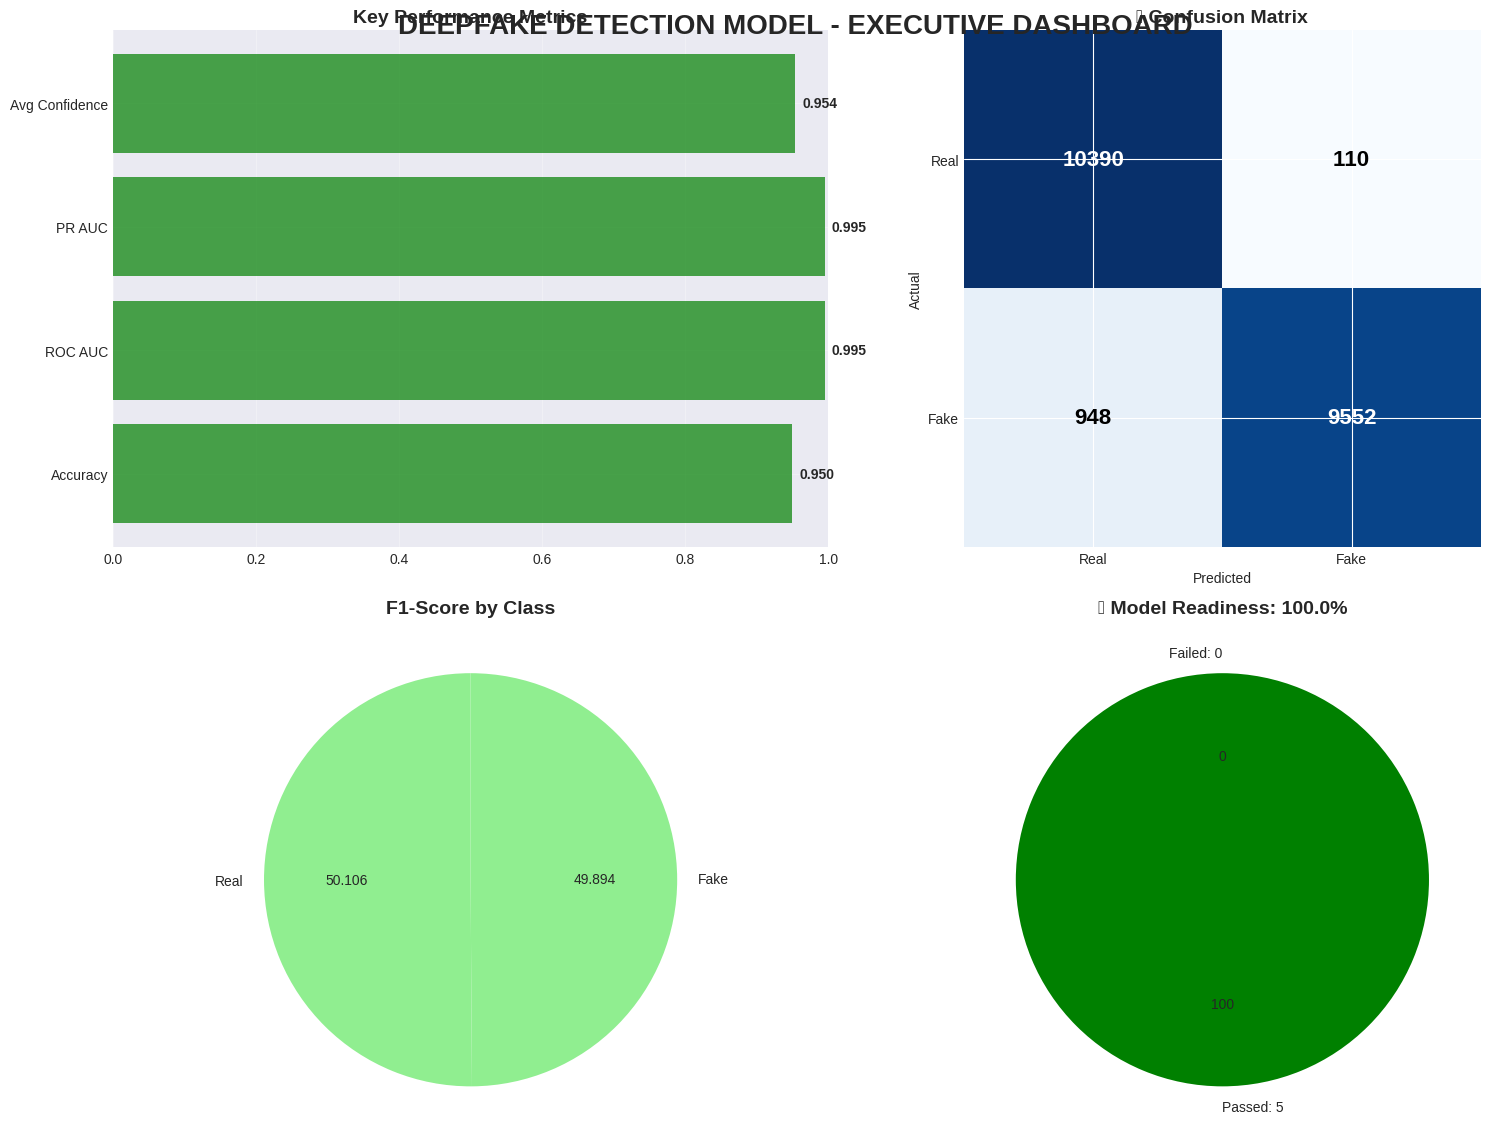


MODEL READINESS ASSESSMENT
Accuracy ≥ 93%            | PASS
ROC AUC ≥ 0.95            | PASS
PR AUC ≥ 0.90             | PASS
High Confidence           | PASS
Balanced Performance      | PASS

Overall Readiness: 100.0% (5/5 criteria met)
MODEL IS PRODUCTION READY!

Analyzing Model Behavior Patterns...


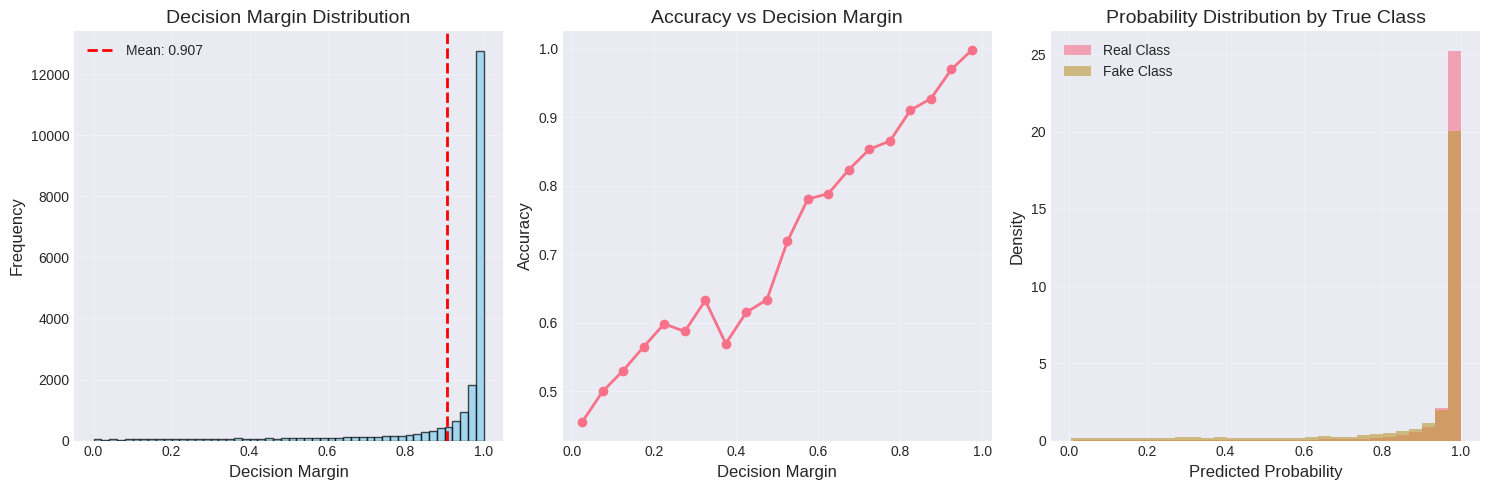

Decision Boundary Analysis:
   Average Decision Margin: 0.9070
   Std Decision Margin: 0.1933
   High Certainty Predictions (margin > 0.8): 18013 (85.8%)


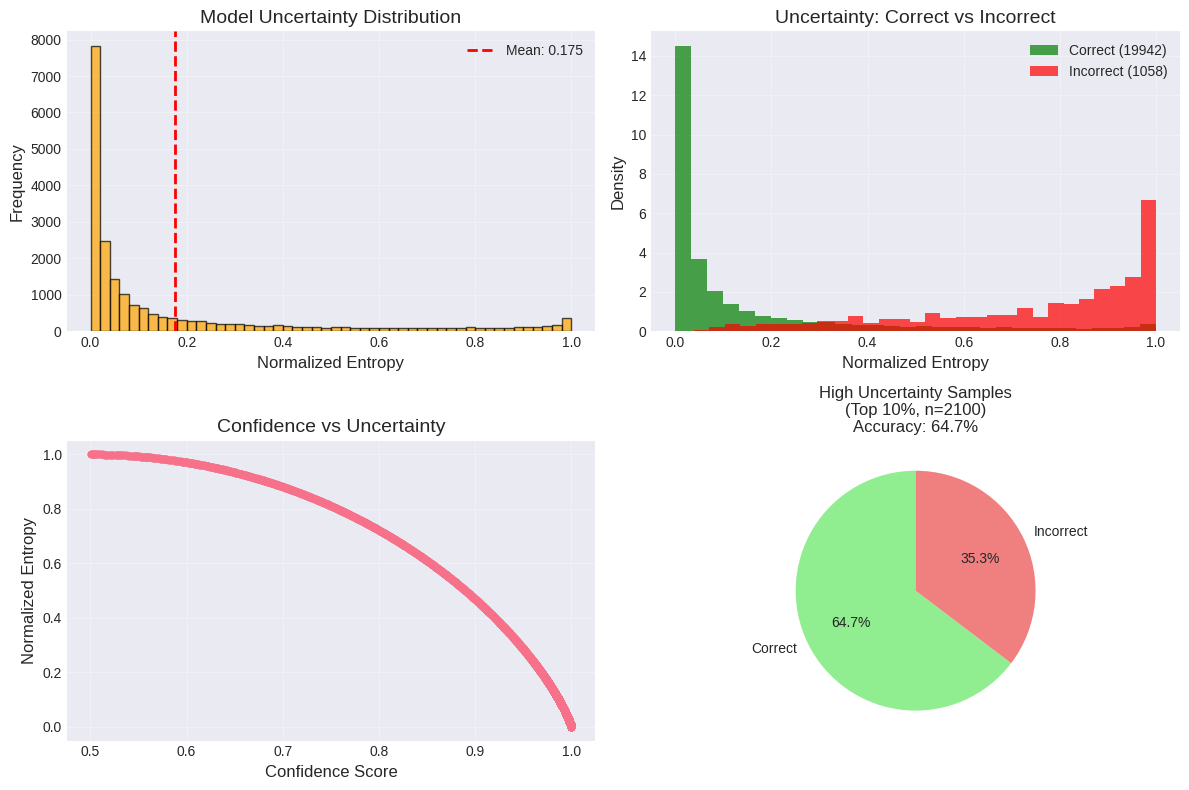

🔍 Uncertainty Analysis:
   Average Uncertainty: 0.1751
   High Uncertainty Samples: 2100 (10.0%)
   High Uncertainty Accuracy: 64.7%


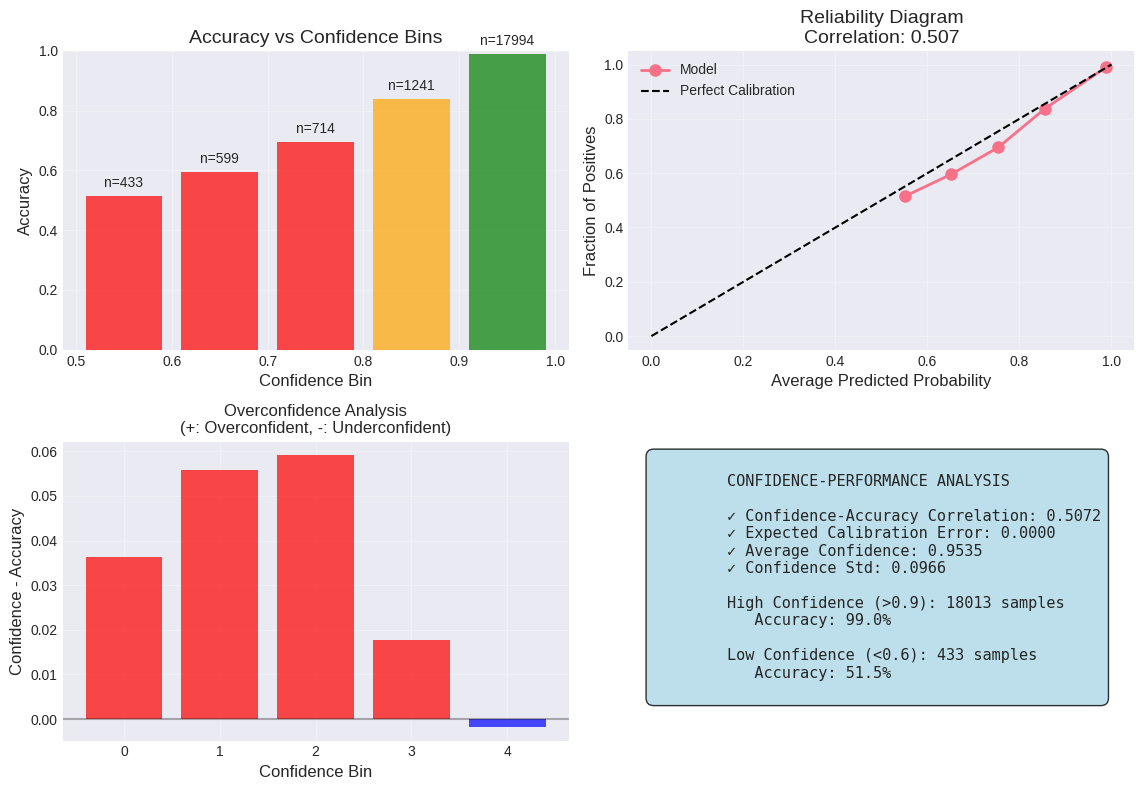

🔗 Confidence-Performance Correlation Analysis:
   Correlation Coefficient: 0.5072
   Expected Calibration Error: 0.0000
    Moderate correlation - Some calibration issues

EXECUTIVE SUMMARY - DEEPFAKE DETECTION MODEL PERFORMANCE

OVERALL PERFORMANCE:
   • Accuracy: 94.96% yes
   • ROC AUC: 0.9951 yes
   • PR AUC: 0.9953 yes

PER-CLASS PERFORMANCE:
   • REAL CLASS:
     - Precision: 91.64%
     - Recall: 98.95%
     - F1-Score: 95.16%
   • FAKE CLASS:
     - Precision: 98.86%
     - Recall: 90.97%
     - F1-Score: 94.75%

 MODEL CONFIDENCE:
   • Average Confidence: 0.9535
   • High Confidence Predictions (>90%): 18013
   • Low Confidence Predictions (<60%): 433

 ERROR ANALYSIS:
   • Total Errors: 1058 out of 21000
   • Error Rate: 5.04%

PRODUCTION READINESS:
   • Status: READY FOR DEPLOYMENT
   • Recommendation: Model meets all performance criteria for production deployment.

 NEXT STEPS:
   1. Export model for browser plugin integration
   2. Implement real-time inference pipeline
  

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import json

# -------------------------------
# 1️⃣ Set device
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name()}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

# -------------------------------
# 2️⃣ Load dataset and create test split
# -------------------------------
# prepare_dataset() must return full dataset paths and labels
image_paths, labels = prepare_dataset()

# Split into train/temp
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)

# Split temp into val/test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Test set size: {len(test_paths)} images")

# -------------------------------
# 3️⃣ Initialize model
# -------------------------------
model = DeepfakeDetector(num_classes=2, dropout=0.3)  # same as training
model = model.to(device)

# -------------------------------
# 4️⃣ Load trained weights
# -------------------------------
checkpoint_path = '/content/drive/MyDrive/deepfake_project/deepfake_detector.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("Trained model loaded successfully!")

# -------------------------------
# 5️⃣ Prepare test dataset and loader
# -------------------------------
test_dataset = DeepfakeDataset(test_paths, test_labels, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# -------------------------------
# 6️⃣ Run comprehensive testing
# -------------------------------
results, analyzer = run_comprehensive_model_testing(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=['Real', 'Fake']
)

print("Testing completed!")
print(f"Test Accuracy: {results['accuracy']:.2f}%")

In [ ]:
import json

# -------------------------------
# Generate project report data
# -------------------------------
project_report = {
    "team_name": "Techie Squad",
    "project_title": "AI-Powered Deepfake Detection for Cybersecurity",
    "model_architecture": "ResNeXt + LSTM",
    "dataset_size": len(test_loader.dataset),
    "final_accuracy": f"{results['accuracy']*100:.2f}%",
    "target_met": "YES" if results['accuracy'] >= 0.93 else "NO",
    "roc_auc": f"{results['roc_auc']:.4f}",
    "production_ready": "YES" if results['accuracy'] >= 0.93 and results['roc_auc'] >= 0.95 else "NO",
    "model_path": "/content/drive/MyDrive/deepfake_project/"
}

# -------------------------------
# Save project report to JSON
# -------------------------------
report_path = '/content/drive/MyDrive/deepfake_project/final_project_report.json'
with open(report_path, 'w') as f:
    json.dump(project_report, f, indent=2)

print(f"Project report saved to: {report_path}")
print("\nReady for browser plugin integration!")

# -------------------------------
# Optional: Print final performance summary
# -------------------------------
print(f"\nFINAL PERFORMANCE SUMMARY:")
print(f"   Test Accuracy: {results['accuracy']*100:.2f}%")
print(f"   ROC AUC Score: {results['roc_auc']:.4f}")
print(f"   Average Confidence: {results['avg_confidence']:.4f}")
print(f"   Target Achieved: {'YES' if results['accuracy'] >= 0.93 else 'NO'}")

Project report saved to: /content/drive/MyDrive/deepfake_project/final_project_report.json

Ready for browser plugin integration!

FINAL PERFORMANCE SUMMARY:
   Test Accuracy: 94.96%
   ROC AUC Score: 0.9951
   Average Confidence: 0.9535
   Target Achieved: YES
